In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
from api_keys import geoapify_key

In [2]:
crime_data = Path("Crime_Reports.csv")

# Read in the data. 
crime_data_df = pd.read_csv(crime_data)
crime_data_df.columns

/var/folders/2h/v467wz0562dfskh2fgt2pqhm0000gn/T/ipykernel_54394/179752030.py:4: DtypeWarning: Columns (16,26) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data_df = pd.read_csv(crime_data)


Index(['Incident Number', 'Highest Offense Description',
       'Highest Offense Code', 'Family Violence', 'Occurred Date Time',
       'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date',
       'Report Time', 'Location Type', 'Address', 'Zip Code',
       'Council District', 'APD Sector', 'APD District', 'PRA', 'Census Tract',
       'Clearance Status', 'Clearance Date', 'UCR Category',
       'Category Description', 'X-coordinate', 'Y-coordinate', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

In [3]:
# Keep only certain columns
reduced_crime_df = crime_data_df.loc[:,['Highest Offense Description', 'Highest Offense Code','Occurred Date','Occurred Time',
                                        'Location Type','Address','Latitude','Longitude','Zip Code','APD Sector','APD District','Clearance Status']]
reduced_crime_df

# Filter lat/long just for Austin area
clean_crime_loc_df = reduced_crime_df.loc[((crime_data_df["Latitude"] <= 31) & (crime_data_df["Latitude"] >= 30)) & 
                                       ((crime_data_df["Longitude"] <= -97.5) & (crime_data_df["Longitude"] >= -98)), :]
clean_crime_loc_df

Highest Offense Description  Highest Offense Code Occurred Date  \
36271          BURGLARY OF RESIDENCE                   500    11/10/2019   
36272           THEFT BY SHOPLIFTING                   607    06/12/2003   
36273            BURGLARY OF VEHICLE                   601    05/26/2011   
36274    CUSTODY ARREST TRAFFIC WARR                  3722    07/10/2003   
36275                     HARASSMENT                  2703    03/20/2005   
...                              ...                   ...           ...   
2371188           FAMILY DISTURBANCE                  3400    12/29/2017   
2371189          BURGLARY OF VEHICLE                   601    04/03/2013   
2371190           FAMILY DISTURBANCE                  3400    02/13/2006   
2371191                        THEFT                   600    04/13/2015   
2371192          DISTURBANCE - OTHER                  3401    01/11/2019   

         Occurred Time                         Location Type  \
36271           2105.0                      RESIDENCE / HOME   
36272           1548.0                 GROCERY / SUPERMARKET   
36273           2000.0                      RESIDENCE / HOME   
36274           2040.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
36275           1200.0                      RESIDENCE / HOME   
...                ...                                   ...   
2371188         1723.0                      RESIDENCE / HOME   
2371189          737.0                      RESIDENCE / HOME   
2371190          900.0                      RESIDENCE / HOME   
2371191          800.0          COMMERCIAL / OFFICE BUILDING   
2371192         1629.0             PARKING /DROP LOT/ GARAGE   

                          Address   Latitude  Longitude  Zip Code APD Sector  \
36271             6800 MC NEIL DR  30.438983 -97.759669   78729.0         AD   
36272              1500 W 35TH ST  30.306590 -97.749015   78731.0         BA   
36273               3200 S 1ST ST  30.233182 -97.765474   78704.0         DA   
36274    2500 E BEN WHITE WB BLVD  30.215810 -97.736915   78741.0         HE   
36275           6810 LEXINGTON RD  30.350269 -97.747427   78757.0         BA   
...                           ...        ...        ...       ...        ...   
2371188  5420 MIDDLE FISKVILLE RD  30.317142 -97.714549   78751.0         ID   
2371189             313 THELMA DR  30.192282 -97.785702   78745.0         FR   
2371190        2612 GARRETTSON DR  30.175552 -97.834125   78748.0         FR   
2371191  4625 W WILLIAM CANNON DR  30.223363 -97.843593   78749.0         DA   
2371192         7401 N LAMAR BLVD  30.340645 -97.715918   78752.0         ID   

        APD District Clearance Status  
36271              4                N  
36272              6                O  
36273              2                N  
36274              2                C  
36275              6              NaN  
...              ...              ...  
2371188            6              NaN  
2371189            3                N  
2371190            1              NaN  
2371191            7                N  
2371192            8                N  

[2333030 rows x 12 columns]

In [4]:
# Add empty columen for Occurred Year
clean_crime_loc_df.insert(3, "Occurred Date - Year", "")
clean_crime_loc_df

Highest Offense Description  Highest Offense Code Occurred Date  \
36271          BURGLARY OF RESIDENCE                   500    11/10/2019   
36272           THEFT BY SHOPLIFTING                   607    06/12/2003   
36273            BURGLARY OF VEHICLE                   601    05/26/2011   
36274    CUSTODY ARREST TRAFFIC WARR                  3722    07/10/2003   
36275                     HARASSMENT                  2703    03/20/2005   
...                              ...                   ...           ...   
2371188           FAMILY DISTURBANCE                  3400    12/29/2017   
2371189          BURGLARY OF VEHICLE                   601    04/03/2013   
2371190           FAMILY DISTURBANCE                  3400    02/13/2006   
2371191                        THEFT                   600    04/13/2015   
2371192          DISTURBANCE - OTHER                  3401    01/11/2019   

        Occurred Date - Year  Occurred Time  \
36271                                2105.0   
36272                                1548.0   
36273                                2000.0   
36274                                2040.0   
36275                                1200.0   
...                      ...            ...   
2371188                              1723.0   
2371189                               737.0   
2371190                               900.0   
2371191                               800.0   
2371192                              1629.0   

                                Location Type                   Address  \
36271                        RESIDENCE / HOME           6800 MC NEIL DR   
36272                   GROCERY / SUPERMARKET            1500 W 35TH ST   
36273                        RESIDENCE / HOME             3200 S 1ST ST   
36274    HWY / ROAD / ALLEY/ STREET/ SIDEWALK  2500 E BEN WHITE WB BLVD   
36275                        RESIDENCE / HOME         6810 LEXINGTON RD   
...                                       ...                       ...   
2371188                      RESIDENCE / HOME  5420 MIDDLE FISKVILLE RD   
2371189                      RESIDENCE / HOME             313 THELMA DR   
2371190                      RESIDENCE / HOME        2612 GARRETTSON DR   
2371191          COMMERCIAL / OFFICE BUILDING  4625 W WILLIAM CANNON DR   
2371192             PARKING /DROP LOT/ GARAGE         7401 N LAMAR BLVD   

          Latitude  Longitude  Zip Code APD Sector APD District  \
36271    30.438983 -97.759669   78729.0         AD            4   
36272    30.306590 -97.749015   78731.0         BA            6   
36273    30.233182 -97.765474   78704.0         DA            2   
36274    30.215810 -97.736915   78741.0         HE            2   
36275    30.350269 -97.747427   78757.0         BA            6   
...            ...        ...       ...        ...          ...   
2371188  30.317142 -97.714549   78751.0         ID            6   
2371189  30.192282 -97.785702   78745.0         FR            3   
2371190  30.175552 -97.834125   78748.0         FR            1   
2371191  30.223363 -97.843593   78749.0         DA            7   
2371192  30.340645 -97.715918   78752.0         ID            8   

        Clearance Status  
36271                  N  
36272                  O  
36273                  N  
36274                  C  
36275                NaN  
...                  ...  
2371188              NaN  
2371189                N  
2371190              NaN  
2371191                N  
2371192                N  

[2333030 rows x 13 columns]

In [5]:
# Split year from occured Date
for index, row in clean_crime_loc_df.iterrows():
    #Get occured date time
    try:
        clean_crime_loc_df.loc[index, "Occurred Date - Year"] = clean_crime_loc_df.loc[index, "Occurred Date"][-4:]
    except:
        clean_crime_loc_df.loc[index, "Occurred Date - Year"] = "NaN"

clean_crime_loc_df



Highest Offense Description  Highest Offense Code Occurred Date  \
36271          BURGLARY OF RESIDENCE                   500    11/10/2019   
36272           THEFT BY SHOPLIFTING                   607    06/12/2003   
36273            BURGLARY OF VEHICLE                   601    05/26/2011   
36274    CUSTODY ARREST TRAFFIC WARR                  3722    07/10/2003   
36275                     HARASSMENT                  2703    03/20/2005   
...                              ...                   ...           ...   
2371188           FAMILY DISTURBANCE                  3400    12/29/2017   
2371189          BURGLARY OF VEHICLE                   601    04/03/2013   
2371190           FAMILY DISTURBANCE                  3400    02/13/2006   
2371191                        THEFT                   600    04/13/2015   
2371192          DISTURBANCE - OTHER                  3401    01/11/2019   

        Occurred Date - Year  Occurred Time  \
36271                   2019         2105.0   
36272                   2003         1548.0   
36273                   2011         2000.0   
36274                   2003         2040.0   
36275                   2005         1200.0   
...                      ...            ...   
2371188                 2017         1723.0   
2371189                 2013          737.0   
2371190                 2006          900.0   
2371191                 2015          800.0   
2371192                 2019         1629.0   

                                Location Type                   Address  \
36271                        RESIDENCE / HOME           6800 MC NEIL DR   
36272                   GROCERY / SUPERMARKET            1500 W 35TH ST   
36273                        RESIDENCE / HOME             3200 S 1ST ST   
36274    HWY / ROAD / ALLEY/ STREET/ SIDEWALK  2500 E BEN WHITE WB BLVD   
36275                        RESIDENCE / HOME         6810 LEXINGTON RD   
...                                       ...                       ...   
2371188                      RESIDENCE / HOME  5420 MIDDLE FISKVILLE RD   
2371189                      RESIDENCE / HOME             313 THELMA DR   
2371190                      RESIDENCE / HOME        2612 GARRETTSON DR   
2371191          COMMERCIAL / OFFICE BUILDING  4625 W WILLIAM CANNON DR   
2371192             PARKING /DROP LOT/ GARAGE         7401 N LAMAR BLVD   

          Latitude  Longitude  Zip Code APD Sector APD District  \
36271    30.438983 -97.759669   78729.0         AD            4   
36272    30.306590 -97.749015   78731.0         BA            6   
36273    30.233182 -97.765474   78704.0         DA            2   
36274    30.215810 -97.736915   78741.0         HE            2   
36275    30.350269 -97.747427   78757.0         BA            6   
...            ...        ...       ...        ...          ...   
2371188  30.317142 -97.714549   78751.0         ID            6   
2371189  30.192282 -97.785702   78745.0         FR            3   
2371190  30.175552 -97.834125   78748.0         FR            1   
2371191  30.223363 -97.843593   78749.0         DA            7   
2371192  30.340645 -97.715918   78752.0         ID            8   

        Clearance Status  
36271                  N  
36272                  O  
36273                  N  
36274                  C  
36275                NaN  
...                  ...  
2371188              NaN  
2371189                N  
2371190              NaN  
2371191                N  
2371192                N  

[2333030 rows x 13 columns]

In [6]:
# Drop NAs from data, export cleaned data to csv
clean_crime_df = clean_crime_loc_df.dropna()

clean_crime_df.to_csv("Output/crime_report_cleaned.csv", index=False, header=True)

In [7]:
# Get data for alcohol and marajuana related reports

df_csv_alcohol = clean_crime_df.loc[(clean_crime_df["Highest Offense Code"] == 2100) |
                              (clean_crime_df["Highest Offense Code"] == 2102) |
                              (clean_crime_df["Highest Offense Code"] == 2111) |
                              (clean_crime_df["Highest Offense Code"] == 2103) |
                              (clean_crime_df["Highest Offense Code"] == 2108) |
                              (clean_crime_df["Highest Offense Code"] == 3211) |
                              (clean_crime_df["Highest Offense Code"] == 2209) |
                              (clean_crime_df["Highest Offense Code"] == 2200) |
                              (clean_crime_df["Highest Offense Code"] == 2109) |
                              (clean_crime_df["Highest Offense Code"] == 2206) |
                              (clean_crime_df["Highest Offense Code"] == 2208) |
                              (clean_crime_df["Highest Offense Code"] == 2107) |
                              (clean_crime_df["Highest Offense Code"] == 2106) |
                              (clean_crime_df["Highest Offense Code"] == 2105) |
                              (clean_crime_df["Highest Offense Code"] == 108) |
                              (clean_crime_df["Highest Offense Code"] == 2110) |
                              (clean_crime_df["Highest Offense Code"] == 2202) |
                              (clean_crime_df["Highest Offense Code"] == 2203) |
                              (clean_crime_df["Highest Offense Code"] == 2104),:]

df_csv_mj = clean_crime_df.loc[(clean_crime_df["Highest Offense Code"] == 1803) |
                              (clean_crime_df["Highest Offense Code"] == 1825) |
                              (clean_crime_df["Highest Offense Code"] == 1807) |
                              (clean_crime_df["Highest Offense Code"] == 1826) |
                              (clean_crime_df["Highest Offense Code"] == 1827) |
                              (clean_crime_df["Highest Offense Code"] == 1827),:]

# Print results:
print(f"We have {len(df_csv_alcohol)} alcohol crimes and "\
      f"{len(df_csv_mj)} mj crimes in Austin.")

We have 94193 alcohol crimes and 31308 mj crimes in Austin.


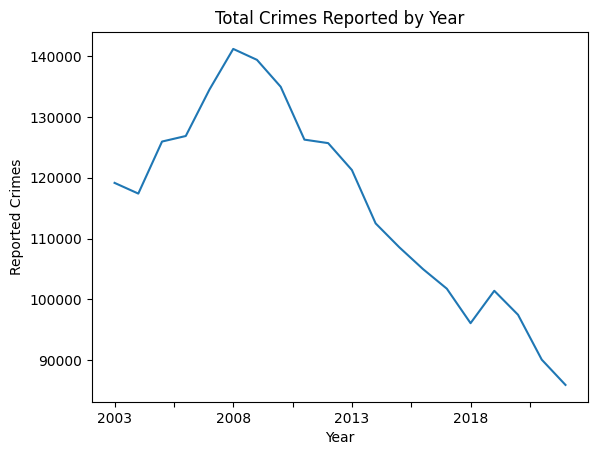

In [8]:
# Show graph of number of crimes by year

crime_counts_by_year = clean_crime_loc_df["Occurred Date - Year"].value_counts().sort_index()
crime_counts_by_year = crime_counts_by_year.drop(index="2023")
xticklabels = crime_counts_by_year.index
crime_by_year = crime_counts_by_year.plot(kind="line",title="Total Crimes Reported by Year", xlabel="Year", 
                                          ylabel="Reported Crimes")


<Axes: >

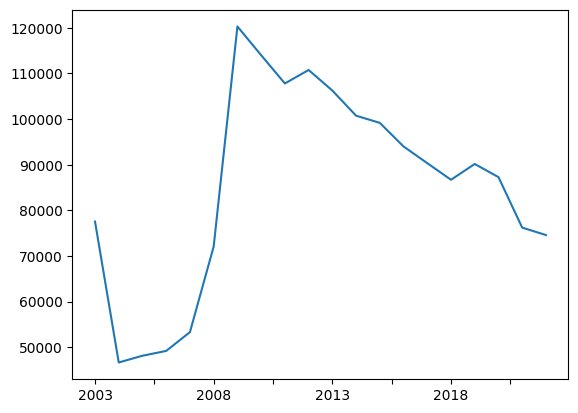

In [9]:
# Show graph of number of crimes by year

crime_counts_by_year = clean_crime_df["Occurred Date - Year"].value_counts().sort_index()
crime_counts_by_year = crime_counts_by_year.drop(index="2023")
crime_counts_by_year.plot(kind="line")

<Axes: title={'center': 'Total Alcohol Crimes Reported by Year'}, xlabel='Year', ylabel='Reported Crimes'>

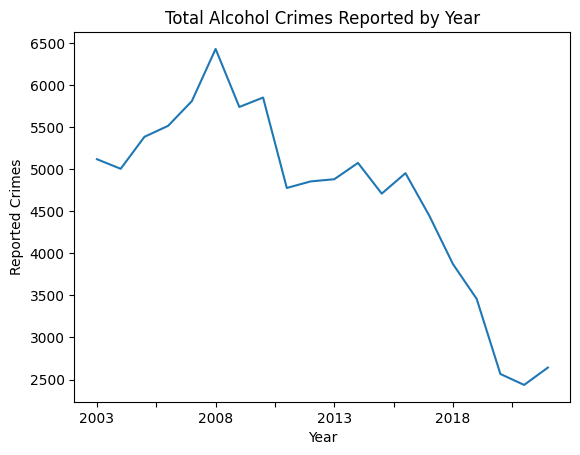

In [10]:
# Show graph of number of crimes by year

alc_crime_counts_by_year = df_csv_alcohol["Occurred Date - Year"].value_counts().sort_index()

alc_crime_counts_by_year = alc_crime_counts_by_year.drop(index="2023")
alc_crime_counts_by_year.plot(kind="line",title="Total Alcohol Crimes Reported by Year", xlabel="Year", 
                                          ylabel="Reported Crimes")

<Axes: title={'center': 'Total Marijuana Reported by Year'}, xlabel='Year', ylabel='Reported Crimes'>

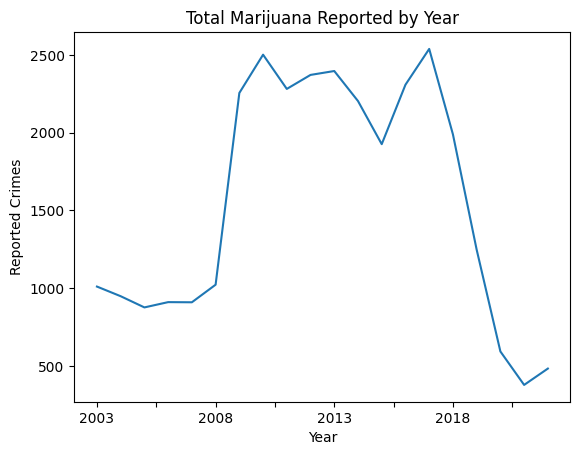

In [11]:
# Show graph of number of crimes by year

mj_crime_counts_by_year = df_csv_mj["Occurred Date - Year"].value_counts().sort_index()
mj_crime_counts_by_year = mj_crime_counts_by_year.drop(index="2023")
mj_crime_counts_by_year.plot(kind="line",title="Total Marijuana Reported by Year", xlabel="Year", 
                                          ylabel="Reported Crimes")

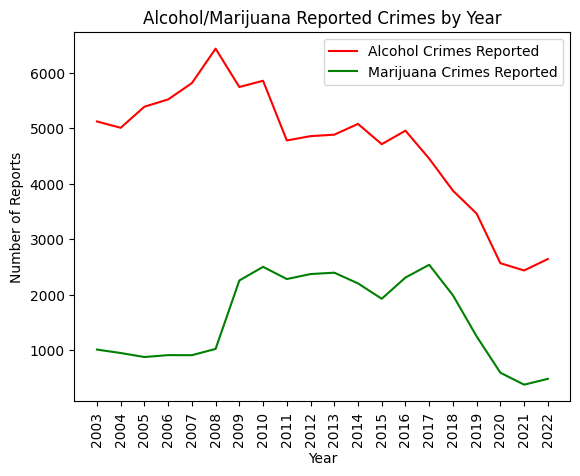

In [12]:
#tot_crime, = plt.plot(crime_counts_by_year.keys(), crime_counts_by_year, color='blue', label="Total Crimes Reported")
alc_crime, = plt.plot(alc_crime_counts_by_year.keys(), alc_crime_counts_by_year, color='red', label="Alcohol Crimes Reported")
mj_crime, = plt.plot(mj_crime_counts_by_year.keys(), mj_crime_counts_by_year, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime, mj_crime], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Year")
plt.ylabel("Number of Reports")
plt.xlabel("Year")
plt.xkcd(scale=1, length=100, randomness=2)

plt.show()

In [13]:
df_csv_mj['Month']=pd.to_datetime(df_csv_mj['Occurred Date']).dt.strftime('%m')
#df_mj.columns

df_csv_alcohol['Month']=pd.to_datetime(df_csv_alcohol['Occurred Date']).dt.strftime('%m')
df_csv_alcohol.columns

/var/folders/2h/v467wz0562dfskh2fgt2pqhm0000gn/T/ipykernel_54394/408270823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv_mj['Month']=pd.to_datetime(df_csv_mj['Occurred Date']).dt.strftime('%m')
/var/folders/2h/v467wz0562dfskh2fgt2pqhm0000gn/T/ipykernel_54394/408270823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv_alcohol['Month']=pd.to_datetime(df_csv_alcohol['Occurred Date']).dt.strftime('%m')


Index(['Highest Offense Description', 'Highest Offense Code', 'Occurred Date',
       'Occurred Date - Year', 'Occurred Time', 'Location Type', 'Address',
       'Latitude', 'Longitude', 'Zip Code', 'APD Sector', 'APD District',
       'Clearance Status', 'Month'],
      dtype='object')

In [14]:
#grouping alcohol reported crimes by month and year
OHyear_2017=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2017')]
month_oh17=OHyear_2017.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2018=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2018')]
month_oh18=OHyear_2018.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2019=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2019')]
month_oh19=OHyear_2019.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2020=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2020')]
month_oh20=OHyear_2020.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2021=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2021')]
month_oh21=OHyear_2021.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2022=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2022')]
month_oh22=OHyear_2022.groupby(["Month"])['Highest Offense Description'].count().sort_index()

In [15]:
#grouping marijuana reported crimes by month and year
year_2017=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2017')]
month_mj17=year_2017.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2018=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2018')]
month_mj18=year_2018.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2019=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2019')]
month_mj19=year_2019.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2020=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2020')]
month_mj20=year_2020.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2021=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2021')]
month_mj21=year_2021.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2022=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2022')]
month_mj22=year_2022.groupby(["Month"])['Highest Offense Description'].count().sort_index()



Text(0.5, 0, 'Months')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

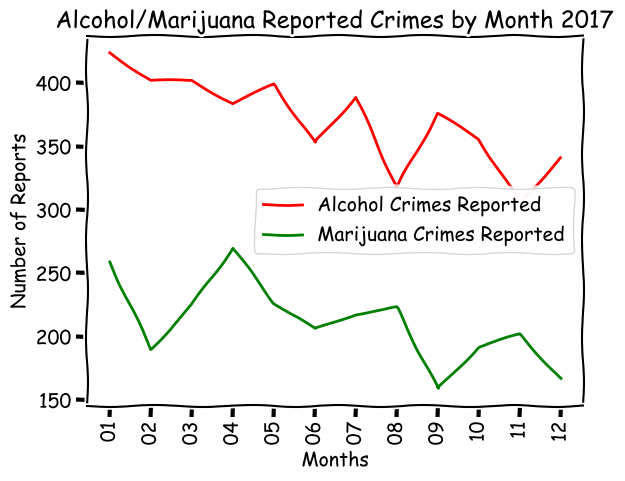

In [16]:
#monthly plot alcohol and mj 2017
alc_crime17, = plt.plot(month_oh17.keys(), month_oh17, color='red', label="Alcohol Crimes Reported")
mj_crime17, = plt.plot(month_mj17.keys(), month_mj17, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime17, mj_crime17], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2017")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

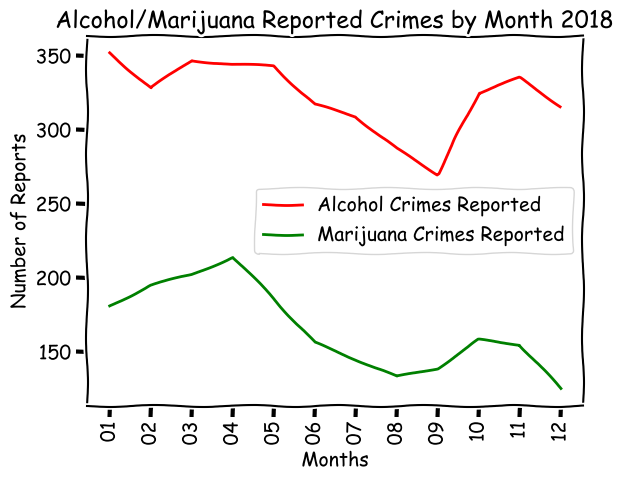

In [17]:
#monthly plot alcohol and mj 2018
alc_crime18, = plt.plot(month_oh18.keys(), month_oh18, color='red', label="Alcohol Crimes Reported")
mj_crime18, = plt.plot(month_mj18.keys(), month_mj18, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime18, mj_crime18], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2018")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

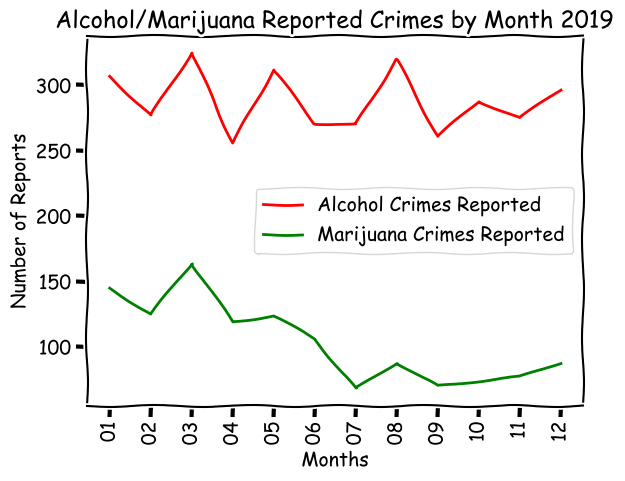

In [18]:
#monthly plot alcohol and mj 2019
alc_crime19, = plt.plot(month_oh19.keys(), month_oh19, color='red', label="Alcohol Crimes Reported")
mj_crime19, = plt.plot(month_mj19.keys(), month_mj19, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime19, mj_crime19], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2019")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

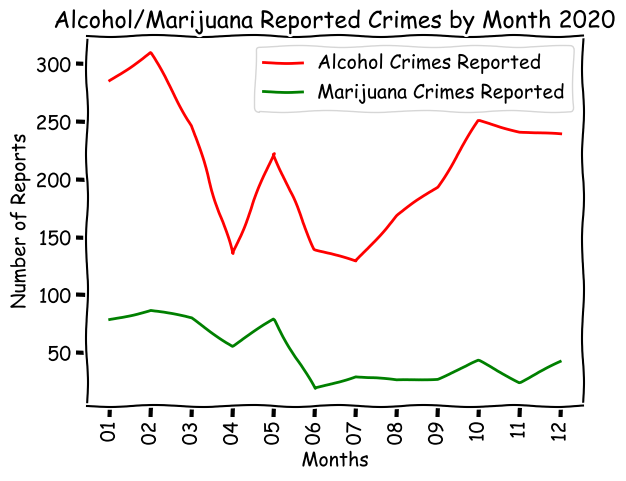

In [19]:
#monthly plot alcohol and mj 2020
alc_crime20, = plt.plot(month_oh20.keys(), month_oh20, color='red', label="Alcohol Crimes Reported")
mj_crime20, = plt.plot(month_mj20.keys(), month_mj20, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime20, mj_crime20], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2020")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

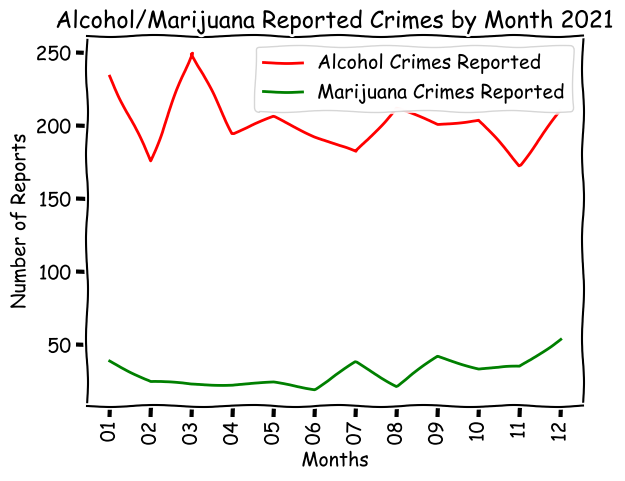

In [20]:
#monthly plot alcohol and mj 2021
alc_crime21, = plt.plot(month_oh21.keys(), month_oh21, color='red', label="Alcohol Crimes Reported")
mj_crime21, = plt.plot(month_mj21.keys(), month_mj21, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime21, mj_crime21], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2021")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

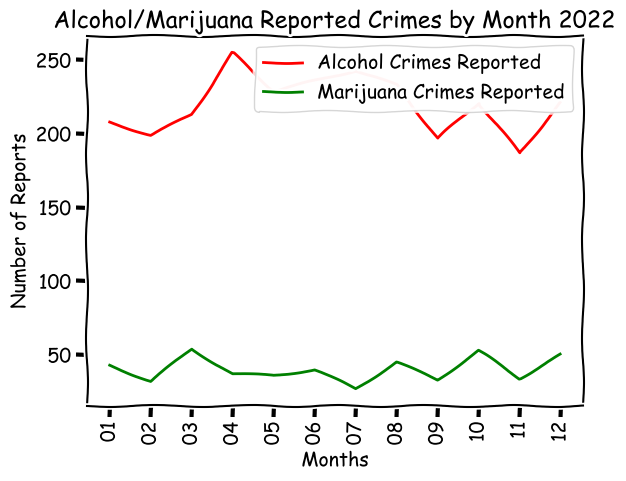

In [21]:
#monthly plot alcohol and mj 2022
alc_crime22, = plt.plot(month_oh22.keys(), month_oh22, color='red', label="Alcohol Crimes Reported")
mj_crime22, = plt.plot(month_mj22.keys(), month_mj22, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime22, mj_crime22], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2022")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

In [22]:
#Find correlation between MJ reported crimes and alcohol from 2003 to 2023
#create new df
OH_crime_count_zc=df_csv_alcohol["Zip Code"].value_counts().sort_index()
mj_crime_count_zc=df_csv_mj["Zip Code"].value_counts().sort_index()
mj_oh=pd.DataFrame({"Marihuana":mj_crime_count_zc,"Alcohol":OH_crime_count_zc})
mj_oh.fillna(0, inplace=True)


In [23]:
mj_oh.describe()

Marihuana       Alcohol
count    58.000000     58.000000
mean    539.793103   1624.017241
std     909.260366   2586.045776
min       0.000000      1.000000
25%       8.500000     41.500000
50%     140.500000    502.500000
75%     562.750000   1785.250000
max    3682.000000  12011.000000

The r-value is: 0.8663940682520423


<function matplotlib.pyplot.show(close=None, block=None)>

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

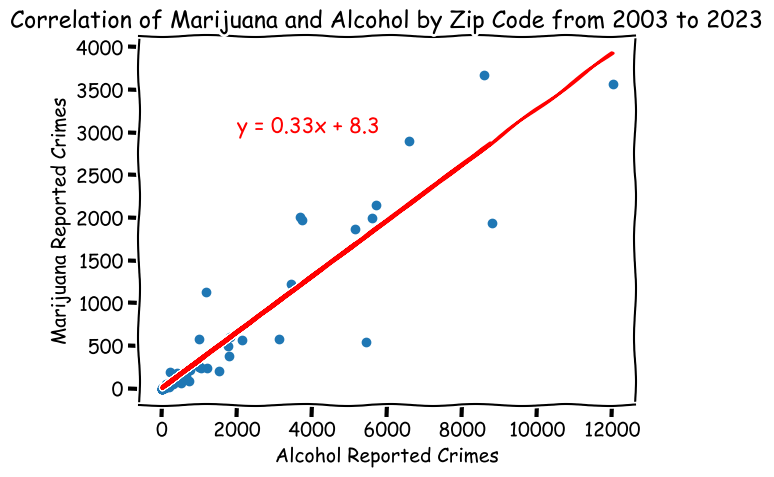

In [24]:
#plot correlation
y=mj_oh["Marihuana"].astype('float')
x=mj_oh["Alcohol"].astype('float')

#linear regression
(slope,intercept,rvalue,pvalue,stderr)= linregress(x,y)
regress_values= x * slope + intercept
line_eq="y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plot
plt.scatter(x,y)
plt.plot(x,regress_values, "r-")
plt.title("Correlation of Marijuana and Alcohol by Zip Code from 2003 to 2023")
plt.xlabel("Alcohol Reported Crimes")
plt.ylabel("Marijuana Reported Crimes")
plt.annotate(line_eq,(2000,3000),fontsize=15,color="red")
#R value
print(f"The r-value is: {rvalue**2}")
plt.show

In [25]:
#Determine Correlation
y=mj_oh["Marihuana"]
x=mj_oh["Alcohol"]
correlation= st.pearsonr(x,y)
print(f"The correlation between both is {round(correlation[0],2)}")

The correlation between both is 0.93


In [26]:
mj_map = df_csv_mj.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500
)

mj_map


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

In [27]:
alcohol_map = df_csv_alcohol.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500
)

alcohol_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

In [28]:
# Show graph of number of alcohol crimes by zip

alc_crime_counts_by_zip = df_csv_alcohol["Zip Code"].value_counts().sort_index()
#crime_counts_by_year.sort_index(ascending=True)
alc_crime_counts_by_zip

78610.0        9
78613.0      191
78617.0      396
78626.0        1
78634.0        1
78640.0        1
78641.0        2
78642.0        1
78645.0        1
78652.0       18
78653.0       61
78660.0      364
78664.0       20
78665.0        1
78681.0       27
78701.0    12011
78702.0     6574
78703.0     5427
78704.0     8778
78705.0     2133
78712.0       98
78717.0      510
78719.0      202
78721.0     1162
78722.0      879
78723.0     3676
78724.0      994
78725.0      108
78726.0      296
78727.0     1002
78728.0      191
78729.0      734
78730.0       79
78731.0     1529
78732.0       35
78733.0        5
78734.0        4
78735.0      729
78736.0      111
78737.0       21
78739.0       93
78741.0     8588
78742.0       98
78744.0     3736
78745.0     5591
78746.0     1195
78747.0      495
78748.0     1816
78749.0     1032
78750.0      991
78751.0     1750
78752.0     3449
78753.0     5712
78754.0      543
78756.0      653
78757.0     1797
78758.0     5146
78759.0     3126
Name: Zip Code

In [29]:
zip_alc_df = pd.DataFrame(df_csv_alcohol["Zip Code"].value_counts())
zip_alc_df.insert(1, "Latitude", "")
zip_alc_df.insert(2, "Longitude", "")

len(zip_alc_df)

58

In [30]:
zip_alc_df = zip_alc_df.rename(columns={"Zip Code": "Number of Reports"})
zip_alc_df.insert(3, "Zip Code", "")
zip_alc_df

Number of Reports Latitude Longitude Zip Code
78701.0              12011                            
78704.0               8778                            
78741.0               8588                            
78702.0               6574                            
78753.0               5712                            
78745.0               5591                            
78703.0               5427                            
78758.0               5146                            
78744.0               3736                            
78723.0               3676                            
78752.0               3449                            
78759.0               3126                            
78705.0               2133                            
78748.0               1816                            
78757.0               1797                            
78751.0               1750                            
78731.0               1529                            
78746.0               1195                            
78721.0               1162                            
78749.0               1032                            
78727.0               1002                            
78724.0                994                            
78750.0                991                            
78722.0                879                            
78729.0                734                            
78735.0                729                            
78756.0                653                            
78754.0                543                            
78717.0                510                            
78747.0                495                            
78617.0                396                            
78660.0                364                            
78726.0                296                            
78719.0                202                            
78613.0                191                            
78728.0                191                            
78736.0                111                            
78725.0                108                            
78742.0                 98                            
78712.0                 98                            
78739.0                 93                            
78730.0                 79                            
78653.0                 61                            
78732.0                 35                            
78681.0                 27                            
78737.0                 21                            
78664.0                 20                            
78652.0                 18                            
78610.0                  9                            
78733.0                  5                            
78734.0                  4                            
78641.0                  2                            
78626.0                  1                            
78665.0                  1                            
78640.0                  1                            
78645.0                  1                            
78634.0                  1                            
78642.0                  1

In [31]:
# Set parameters to search for zip long, lat

params = {
    "type":"postcode",
    "apiKey":geoapify_key
}

# Print a message to follow up the hotel search
print("Starting zip search")

for index, row in zip_alc_df.iterrows():
    
    # get Zip Code from the DataFrame, convert from float to object, drop decimal
    ind = str(index)[:-2]
    
    # Set base URL
    base_url = "https://api.geoapify.com/v1/geocode/search?text=" + ind


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    #print(json.dumps(name_address, indent=4))
    # break

    try:
        if name_address["features"][0]["properties"]["city"] == 'Austin':

            zip_alc_df.loc[index, "Zip Code"] = ind
    
            try:
                zip_alc_df.loc[index, "Latitude"] = name_address["features"][0]["properties"]["lat"]
                zip_alc_df.loc[index, "Longitude"] = name_address["features"][0]["properties"]["lon"]
            except (KeyError, IndexError):
                print("No Zip " + ind)
        else:
            #print("not in austin")
            zip_alc_df = zip_alc_df.drop(index=index)
    except (KeyError, IndexError):
        #print("Not in Austin")
        zip_alc_df = zip_alc_df.drop(index=index)
       
# Display sample data

zip_alc_df


Starting zip search


Empty DataFrame
Columns: [Number of Reports, Latitude, Longitude, Zip Code]
Index: []

In [32]:
#len(zip_alc_df)
zip_alc_df = zip_alc_df.sort_index()
zip_alc_df

Empty DataFrame
Columns: [Number of Reports, Latitude, Longitude, Zip Code]
Index: []

In [33]:
try:
    #zip_map = zip_alc_df.hvplot.labels(x="Latitude", y="Longitude", title="Alcohol Reported Crimes by Zip Code")
    zip_map = zip_alc_df.hvplot.points(
        "Longitude",
        "Latitude",
        geo = True,
        tiles = "OSM",
        size = "Number of Reports",
        color="Zip Code",
        frame_width = 700,
        frame_height = 500
    ).opts(title="Alcohol Reported Crimes by Zip Code")
except:
    print("nope")

zip_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Zip Code,Number of Reports)

In [34]:
zip_mj_df = pd.DataFrame(df_csv_mj["Zip Code"].value_counts())
zip_mj_df.insert(1, "Latitude", "")
zip_mj_df.insert(2, "Longitude", "")

len(zip_mj_df)

51

In [35]:
zip_mj_df = zip_mj_df.rename(columns={"Zip Code": "Number of Reports"})
zip_mj_df.insert(3, "Zip Code", "")
zip_mj_df

Number of Reports Latitude Longitude Zip Code
78741.0               3682                            
78701.0               3572                            
78702.0               2902                            
78753.0               2156                            
78723.0               2017                            
78745.0               1998                            
78744.0               1973                            
78704.0               1938                            
78758.0               1870                            
78752.0               1222                            
78721.0               1138                            
78748.0                604                            
78759.0                577                            
78724.0                577                            
78705.0                567                            
78703.0                550                            
78751.0                500                            
78757.0                384                            
78722.0                292                            
78727.0                255                            
78750.0                250                            
78746.0                248                            
78749.0                247                            
78729.0                221                            
78731.0                206                            
78719.0                193                            
78617.0                182                            
78754.0                168                            
78756.0                148                            
78747.0                133                            
78735.0                 86                            
78660.0                 76                            
78717.0                 66                            
78726.0                 56                            
78725.0                 53                            
78712.0                 32                            
78613.0                 27                            
78736.0                 26                            
78739.0                 23                            
78728.0                 21                            
78742.0                 19                            
78732.0                 10                            
78653.0                 10                            
78730.0                  8                            
78652.0                  7                            
78681.0                  6                            
78737.0                  3                            
78664.0                  3                            
78733.0                  3                            
78641.0                  2                            
78734.0                  1

In [36]:
# Set parameters to search for zip long, lat

params = {
    "type":"postcode",
    "apiKey":geoapify_key
}

# Print a message to follow up the hotel search
print("Starting zip search")

for index, row in zip_mj_df.iterrows():
    
    # get Zip Code from the DataFrame, convert from float to object, drop decimal
    ind = str(index)[:-2]
    
    # Set base URL
    base_url = "https://api.geoapify.com/v1/geocode/search?text=" + ind


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    #print(json.dumps(name_address, indent=4))
    # break

    try:
        if name_address["features"][0]["properties"]["city"] == 'Austin':

            zip_mj_df.loc[index, "Zip Code"] = ind
    
            try:
                zip_mj_df.loc[index, "Latitude"] = name_address["features"][0]["properties"]["lat"]
                zip_mj_df.loc[index, "Longitude"] = name_address["features"][0]["properties"]["lon"]
            except (KeyError, IndexError):
                print("No Zip " + ind)
        else:
            #print("not in austin")
            zip_mj_df = zip_mj_df.drop(index=index)
    except (KeyError, IndexError):
        #print("Not in Austin")
        zip_mj_df = zip_mj_df.drop(index=index)
       
# Display sample data

zip_mj_df

Starting zip search


Empty DataFrame
Columns: [Number of Reports, Latitude, Longitude, Zip Code]
Index: []

In [37]:
zip_mj_df = zip_mj_df.sort_index()
zip_mj_df

Empty DataFrame
Columns: [Number of Reports, Latitude, Longitude, Zip Code]
Index: []

In [38]:
try:
    zip_mj_map = zip_mj_df.hvplot.points(
        "Longitude",
        "Latitude",
        geo = True,
        tiles = "OSM",
        size = "Number of Reports",
        color="Zip Code",
        frame_width = 700,
        frame_height = 500
    ).opts(title="Marijuana Reported Crimes by Zip Code")
except:
    print("nope")

zip_mj_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Zip Code,Number of Reports)

In [39]:
df_csv_alcohol.head()

Highest Offense Description  Highest Offense Code Occurred Date  \
36311                         DWI                  2100    01/18/2013   
36325                         DWI                  2100    02/07/2008   
36330                         DWI                  2100    12/29/2021   
36337                         DWI                  2100    06/17/2006   
36353                         DWI                  2100    09/02/2022   

      Occurred Date - Year  Occurred Time  \
36311                 2013          347.0   
36325                 2008          243.0   
36330                 2021         1751.0   
36337                 2006          152.0   
36353                 2022         1658.0   

                              Location Type                    Address  \
36311  HWY / ROAD / ALLEY/ STREET/ SIDEWALK       6430 S IH 35 SVRD SB   
36325  HWY / ROAD / ALLEY/ STREET/ SIDEWALK       500 BLOCK TRINITY ST   
36330  HWY / ROAD / ALLEY/ STREET/ SIDEWALK  1819 S PLEASANT VALLEY RD   
36337  HWY / ROAD / ALLEY/ STREET/ SIDEWALK           1500 BETTY JO DR   
36353  HWY / ROAD / ALLEY/ STREET/ SIDEWALK           4900 WEIDEMAR LN   

        Latitude  Longitude  Zip Code APD Sector APD District  \
36311  30.191337 -97.771015   78745.0         FR            4   
36325  30.266619 -97.739588   78701.0         GE            2   
36330  30.234221 -97.720434   78741.0         HE            3   
36337  30.244446 -97.737140   78704.0         HE            1   
36353  30.208282 -97.760996   78745.0         DA            3   

      Clearance Status Month  
36311                C    01  
36325                C    02  
36330                C    12  
36337                C    06  
36353                C    09

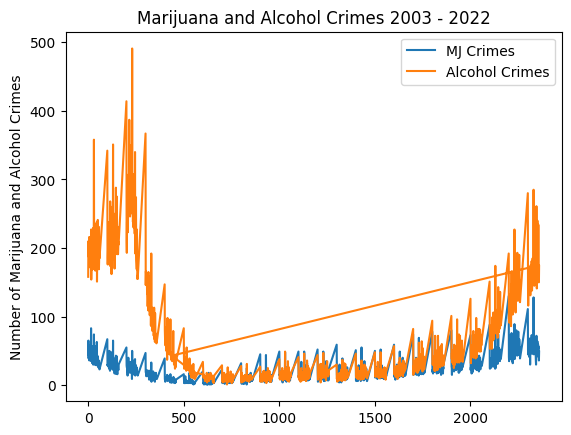

In [40]:
import importlib
importlib.reload(plt)  # Remove and reimport the module
# crime_counts_by_year = df_filtered_renamed_datetime_loc_na_crime_data["Occurred Time"].value_counts().sort_index()
crime_counts_by_year_mj = df_csv_mj["Occurred Time"].value_counts().sort_index()
crime_counts_by_year_alcohol = df_csv_alcohol["Occurred Time"].value_counts().sort_index()

# Combine data from all three dataframes
# combined_data = pd.concat([crime_counts_by_year, crime_counts_by_year_mj, crime_counts_by_year_alcohol], axis=1)
# combined_data.columns = ["Total Crimes", "MJ Crimes", "Alcohol Crimes"]
combined_data = pd.concat([crime_counts_by_year_mj, crime_counts_by_year_alcohol], axis=1)
combined_data.columns = ["MJ Crimes", "Alcohol Crimes"]

# Plot the data on the same graph
# Remove xkcd style
plt.rcdefaults()
plt.xkcd(False)

# Set the default style
plt.style.use('default')

combined_data.plot(kind="line",ylabel = "Number of Marijuana and Alcohol Crimes", title = "Marijuana and Alcohol Crimes 2003 - 2022")
plt.show()

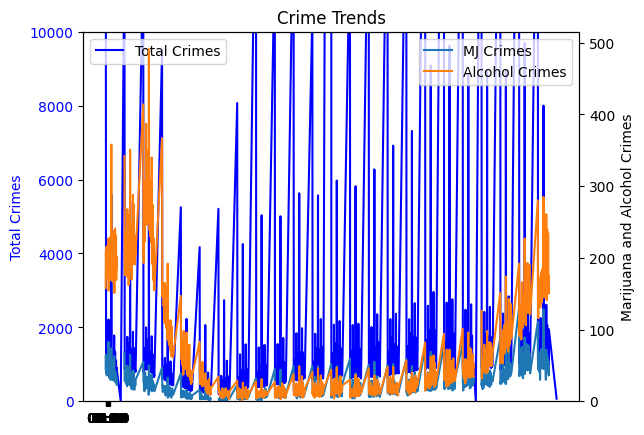

In [41]:
# Get crime counts by year for each dataframe
crime_counts_by_year = clean_crime_df["Occurred Time"].value_counts().sort_index()
crime_counts_by_year_mj = df_csv_mj["Occurred Time"].value_counts().sort_index()
crime_counts_by_year_alcohol = df_csv_alcohol["Occurred Time"].value_counts().sort_index()

# Combine data from all three dataframes
combined_data = pd.concat([crime_counts_by_year, crime_counts_by_year_mj, crime_counts_by_year_alcohol], axis=1)
combined_data.columns = ["Total Crimes", "MJ Crimes", "Alcohol Crimes"]

# Create a new figure and axis objects
fig, ax1 = plt.subplots()

# Plot the total crimes data on the left axis
combined_data["Total Crimes"].plot(kind="line", ax=ax1, color="blue")

# Set the label and y-axis limits for the left axis
ax1.set_ylabel("Total Crimes", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
# Set the y-axis limit for total crimes to be 10,000
ax1.set_ylim(0, 10000)
# ax1.set_ylim(bottom=0)

# Create a second y-axis on the right side of the plot
ax2 = ax1.twinx()

# Plot the marijuana and alcohol crimes data on the right axis
combined_data["MJ Crimes"].plot(kind="line", ax=ax2)
combined_data["Alcohol Crimes"].plot(kind="line", ax=ax2)

# Set the x-axis tick labels to show all 24 hours of the day
ax1.set_xticks(range(0, 24))
ax1.set_xticklabels(["{:02d}:00".format(h) for h in range(0, 24)])

# Set the label and y-axis limits for the right axis
ax2.set_ylabel("Marijuana and Alcohol Crimes", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.set_ylim(bottom=0)

# Add a title and legend to the plot
ax1.set_title("Crime Trends")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


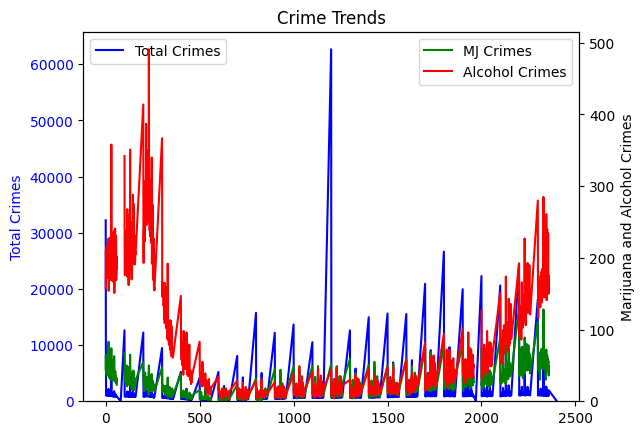

In [42]:
# Get crime counts by year for each dataframe
crime_counts_by_year = clean_crime_df["Occurred Time"].value_counts().sort_index()
crime_counts_by_year_mj = df_csv_mj["Occurred Time"].value_counts().sort_index()
crime_counts_by_year_alcohol = df_csv_alcohol["Occurred Time"].value_counts().sort_index()

# Combine data from all three dataframes
combined_data = pd.concat([crime_counts_by_year, crime_counts_by_year_mj, crime_counts_by_year_alcohol], axis=1)
combined_data.columns = ["Total Crimes", "MJ Crimes", "Alcohol Crimes"]

# Create a new figure and axis objects
fig, ax1 = plt.subplots()

# Plot the total crimes data on the left axis
combined_data["Total Crimes"].plot(kind="line", ax=ax1, color="blue")

# Set the label and y-axis limits for the left axis
ax1.set_ylabel("Total Crimes", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_ylim(bottom=0)

# Create a second y-axis on the right side of the plot
ax2 = ax1.twinx()

# Plot the marijuana and alcohol crimes data on the right axis
combined_data["MJ Crimes"].plot(kind="line", ax=ax2, color="green")
combined_data["Alcohol Crimes"].plot(kind="line", ax=ax2, color="red")

# Set the label and y-axis limits for the right axis
ax2.set_ylabel("Marijuana and Alcohol Crimes", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.set_ylim(bottom=0)

# Add a title and legend to the plot
ax1.set_title("Crime Trends")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


In [43]:
highest_count_time = combined_data["Total Crimes"].idxmax()
print(highest_count_time)

1200.0
